# Lecture and Tutorial . Classification and Regression Trees. Random Forests

### This is a shorter version of the tutorial, that highlights the most necessary information from this topic. 

by Nadzeya Laurentsyeva @ nadzeya.laurentsyeva@econ.lmu.de


In [75]:
# Packages to import 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn import tree as tree


## 1. Highlights 

* **Trees and forests are good tools when we expect to have non-linearities and interactions in our data + when we are agnostic about the data generation process**
<br>

* **When we fit a single tree: trade-off between flexibility and overfitting ($\sim$ bias-variance trade-off)**
<br>

* **Solutions for a single tree**: 
    * Try out different stopping rules
    * Pruning techniques - use CV to select a tree with a smaller number of terminal nodes or use minimal cost-complexity pruning
    * But still variable predictions, sensitive to changes in parameters (e.g. for cross-validation) and sample.
<br>


* **Bagging / Random forests - average over simple CART trees to keep the stable relationships and to average out noise**
    * Bootstrapped samples
    * Extra-randomization 
    * Out-of-bag error estimation 
    * Might not need to specify a stopping rule 
    * Feature importance 
<br>

Self-check: do you understand all the terms here? If not: see the lecture slides

In [76]:
### Illustration 

## What does predict survival on Titanic? 
df = pd.read_csv("data/titanic.csv")
df.head()
# pclass - passenger class 
# sibsp - number of siblings, spouses aboard
# parch - number of parents, children aboard 
# fare - passenger fare
# embarked - port of embarkation 

# Source: https://www.kaggle.com/c/titanic/data

# convert labels to categories 
for i in ['Sex', 'Embarked']:
    df[i] = df[i].astype("category")
    df[f'{i}_cat'] = df[i].cat.codes

In [77]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_cat,Embarked_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,2


In [78]:
df[['Survived', 'Pclass', 'Sex_cat', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_cat']].describe()
# note: we have data for age missing
# a nice discussion how to handle missing values is here https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e 

,Survived,Pclass,Sex_cat,Age,SibSp,Parch,Fare,Embarked_cat
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,1.529742
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.800254
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,2.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


In [79]:
df['Age_imp'] = df['Age'].replace(np.nan, df['Age'].mean())

Tree depth: 4
Tree leaf nodes: 15
Mean accuracy: 0.813


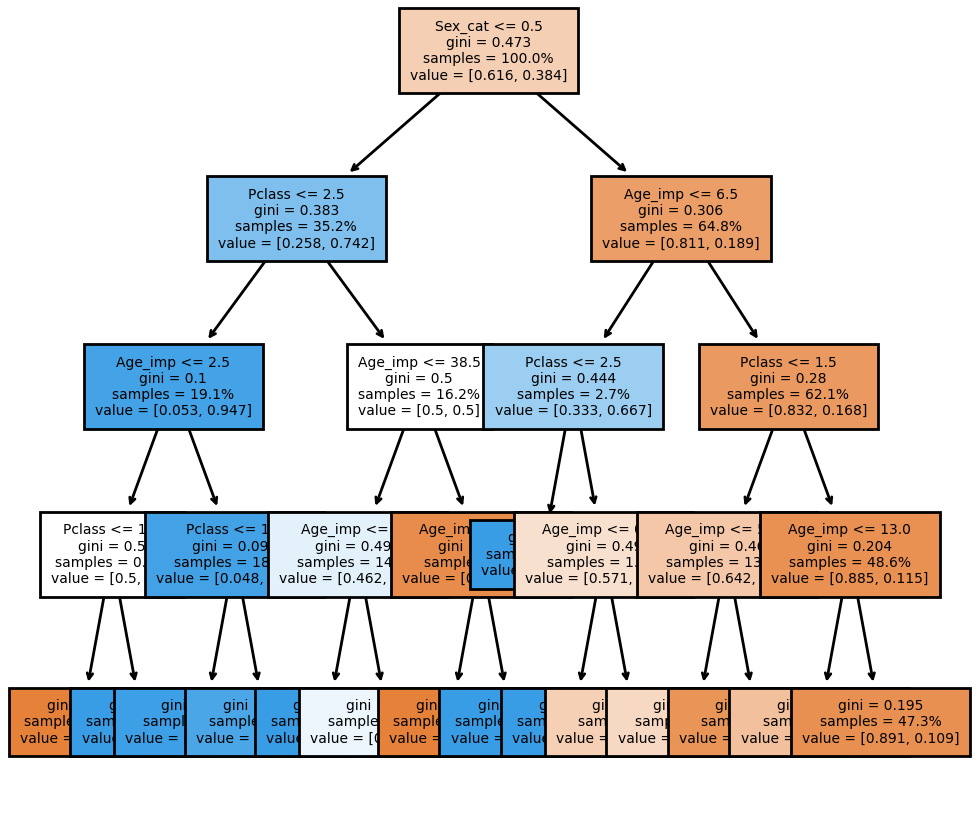

In [80]:
y = df['Survived']
X = df[['Pclass',  'Sex_cat', 'Age_imp']]


cart = tree.DecisionTreeClassifier(min_samples_leaf = 1, min_impurity_decrease = 0, \
                                  min_samples_split=2, max_depth = 4, random_state = 1)
cart.fit(X, y)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Tree leaf nodes: %.0f' % cart.get_n_leaves())
print('Mean accuracy: %.3f'
      % cart.score(X,y))


#dendrogram
matplotlib.rcParams.update({'font.size': 14, 'figure.figsize': (2, 2), 'figure.dpi': 200}) # set's parameters of the figure
tree.plot_tree(cart,  filled = True, feature_names = list(X.columns),\
               fontsize = 5, max_depth = 4, proportion = True);

# value displays the number (or the share, if proportion = True) of observations that fall in each category. 
# e.g. in the first node: 549 - fall in the first category (Survived = 0) and 342 - in the 2nd (Survivied = 1)

## 2. Suggested workflow

* Fit a simple (shallow) tree to examine your data and get the feeling of which features (covariates) are important 
<br> 

* You might try to find an optimal stopping rule (e.g. number of terminal node (leafs)) with CV or minimal cost-complexity pruning, but results might be unstable $\rightarrow$ proceed with a random forest 


* Fit a random forest 
    * Try without a stopping rule first (in case of many covariates, big data or, on the contrary, too few observations, might need to add a simple stopping rule, e.g. max_leaf_nodes, min_samples_leaf or max_depth)
    * Try with/without extra randomization 
    * Determine the optimal number of trees 
        * Either with OOB or with CV
        
<br>

* Compare with other models: OLS, Lasso, etc.
        

In [78]:
# California housing data
# 
df = pd.read_csv("data/CAhousing.csv")
df.describe()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.898014,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.247906,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,295.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


This is the data on house prices in California. The dataset contains median home values (medval) for about 20K census tracks in California. 

Features/independent variables:
* Latitude and longitude of tract centers
* Total population and number of households
* Median income
* Average age of houses, total rooms, total bedrooms

Task
* Predict median home values given covariates
* It is likely that home values and covariate effects change with spatial location, non-linear in longitude and latitude
* How could have we captured this non-linearity in linear models? 

In [79]:
# Before the analysis, we do some transformations. 
# we add variables AveRooms, AveBedrooms, AveOccupancy (assumption: one household lives in one house)
# I do this transformation to make the analysis similar to that in Matt Taddy's book

df['aveRooms'] = df['totalRooms']/df['households']
df['aveBedrooms'] = df['totalBedrooms']/df['households']
df['aveOccupancy'] = df['population']/df['households']
df_tofit = df[['longitude', 'latitude', 'housingMedianAge', 'aveRooms', 'aveBedrooms', \
               'aveOccupancy', 'medianIncome', 'medianHouseValue']]

df_tofit.describe()

,longitude,latitude,housingMedianAge,aveRooms,aveBedrooms,aveOccupancy,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,5.429000,1.096675,3.070655,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2.474173,0.473911,10.386050,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,0.846154,0.333333,0.692308,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,4.440716,1.006079,2.429741,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,5.229129,1.048780,2.818116,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,6.052381,1.099526,3.282261,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,141.909091,34.066667,1243.333333,15.000100,500001.000000


<div class="alert alert-block alert-info">
<b>Question :</b> Shall we transform the variables before fitting CART?  
       
</div>

Answer: 
    
It is not necessary to transform the inputs (a monotonic transformation of our inputs, e.g. a log transformation, will not affect which split is chosen by the algorithm, as we evaluate splits within dimensions). MSE can be affected by the units of the dependent variable $y$ (e.g. when we log-transform $y$, by construction, larger values of $y$ become more homogenous). 

<AxesSubplot:>

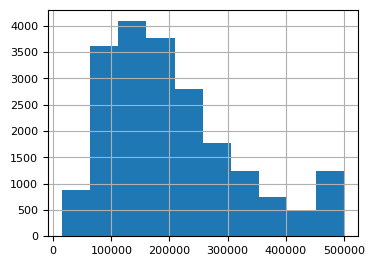

In [80]:
df_tofit['medianHouseValue'].hist()
# as we can see there are some large outliers of medianHouseValue. Therefore, a log transformation seems reasonable. 

<AxesSubplot:>

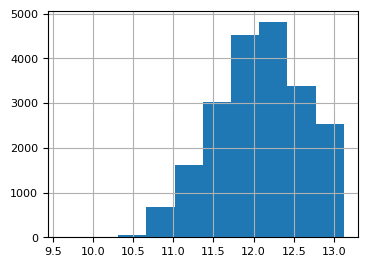

In [81]:
# We generate two datasets: one where only medianHouseValue is transformed and 
# another where we also transform some inputs

df_ylog = df_tofit.copy()
df_alllog = df_tofit.copy()

for x in ['medianHouseValue']:
    df_ylog[x] = np.log(df_ylog[x])
    
for x in ['medianHouseValue', 'aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']:
    df_alllog[x] = np.log(df_alllog[x]) # I do it mainly to show how log transformation of inputs affects the estimations

df_ylog['medianHouseValue'].hist()

## 2. Fitting a simple CART to understand the data 

* Set y and x
* Split the data into training and test samples 
* Fit a simple CART model (you can restrict max_depth for example) on the training sample.


Tree depth: 3
Tree leaf nodes: 8
Out-of-sample Rsq: 0.522
Out-of-sample MSE: 0.157


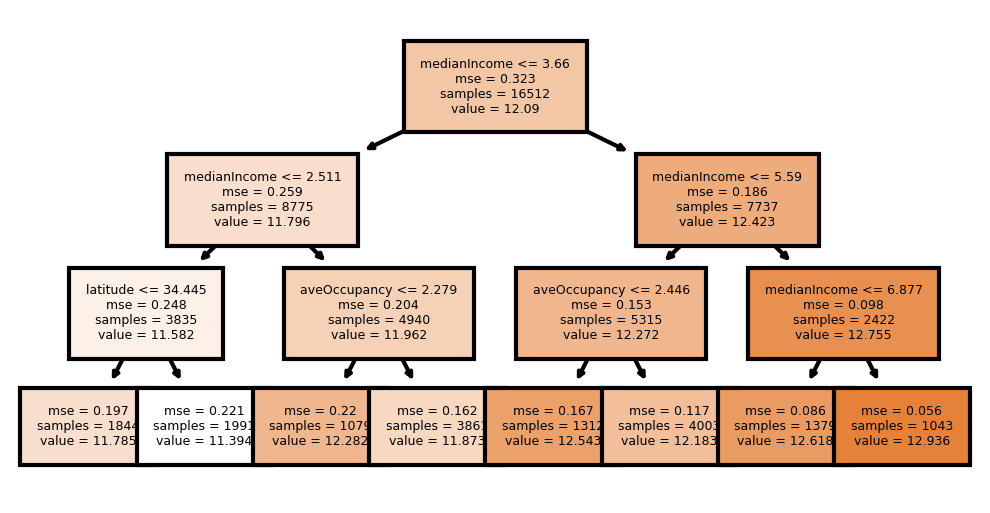

In [82]:
data = df_ylog.copy() # you can check what changes if you use instead df_alllog or df_tofit 

y = data['medianHouseValue'] 
X = data.iloc[:, :7]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html 

# set your own parameters to stabilize the tree
# there is no strong opinion on what stopping rule you should use; may differ across datasets you have. 
# Matt Taddy suggests to use mix_sample_leaf, as it seems to set a simple and a transparent rule.

cart = tree.DecisionTreeRegressor(min_samples_leaf = 1, min_impurity_decrease = 0, \
                                  min_samples_split=2, max_depth = 3, random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Tree leaf nodes: %.0f' % cart.get_n_leaves())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))


#dendrogram
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300}) # set's parameters of the figure
tree.plot_tree(cart, max_depth = 3, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

## 3. Fitting a Random Forest to capture stable relationship

* Without extra randomization 
* With extra randomization (use the additional parameter max_features = int(X.shape[1]/3))
* Optimal number of trees? 
* Which covariates are the most important? Use the property feature_importances_

In [83]:
# now, let's fit a random forest

# Note, there is no strict suggestion whether we should use a stopping rule and/or pruning for individual trees.
# Thereoretically, by aggregating over many trees (even if they individually overfit), we will average-out the noise. 
# Thefore, using fully grown trees rarely causes trouble. I would suggest starting without a stopping rule.

# However, it also depends on the nature of your data (high  noise vs. low noise, the amount of data and dimensions. 
# For instance, it makes sense to apply a stopping rule if you have a small number of observations 
# (you can check this with the last example in the lecture slides, mcycle data, where we only have 133 observations).

# Also when you have a very big dataset, it might make sense to apply a stopping rule, as it will be computationally 
# hard to fit a full tree on your data. 


rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 1,  oob_score = True, \
        random_state = 1)
rf = rf.fit(X_train, y_train)

# Estimate of out-of-sample performance with out-of-bag predictions on the training data 
# Note how close it is to the performance on the test data 
print('OOB Rsq: %.3f'
      % rf.oob_score_)

# Out-of-sample R-sq.
y_pred = rf.predict(X_test)
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

OOB Rsq: 0.829
Out-of-sample Rsq: 0.829
Out-of-sample MSE: 0.056


In [84]:
# let's add an option for extra randomization (for each individual tree, we randomly select a subsample of covariates from X to split on)
# again, here I would recommend checking with and without extra randomization. 

rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

print('OOB Rsq: %.3f'
      % rf.oob_score_)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

OOB Rsq: 0.833
Out-of-sample Rsq: 0.834
Out-of-sample MSE: 0.055


In [85]:
# we can check whether we had enough trees in the forest
# Use cross-validation to determine the optimal number of trees

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 1, \
        random_state = 1)
    cv_result = cross_val_score(rf, X, y, cv=kf, scoring = 'neg_mean_squared_error') # would give you Rsq by default for regression unless you specify the scoring criterion
    avg_score = cv_result.mean()
    return float(-avg_score)

<AxesSubplot:xlabel='Number of trees'>

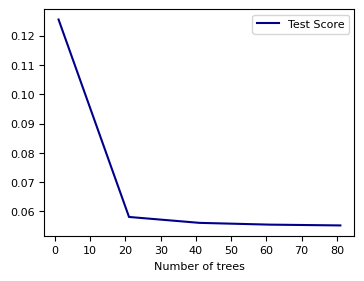

In [86]:
# takes time to run

result = {}
for i in range(1, 100, 20):
    result[i] = cv_iter(i, 5, X_train, y_train)

matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# as we can see on the graph below, the MSE stabilizes with about 40-50 trees. 

## 4. Feature importance 

Use the property feature_importances_ to find out which of the covariates are the most important determinants of House values. 
Create a dataframe that sorts features according to their performance. 

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.feature_importances_
Sklearn calculates the impurity-based feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 

<div class="alert alert-block alert-info">
<b>Question:</b> What are the three most important features? 
    </div>

In [87]:
rf = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
# some details about the implementation in sklearn https://stats.stackexchange.com/questions/311488/summing-feature-importance-in-scikit-learn-for-a-set-of-features
imp['Feature'] = list(X.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)

,Feature importance,Feature
0,0.344901,medianIncome
1,0.174294,latitude
2,0.170600,longitude
3,0.111059,aveRooms
4,0.106483,aveOccupancy
5,0.046528,aveBedrooms
6,0.046135,housingMedianAge


**Important: to not overinterpret feature importance as causal**

## 5. Comparison with OLS and LASSO models

<div class="alert alert-block alert-info">
<b>Question:</b> Comparison with OLS and LASSO 
    
* Review lecture 1 and try fitting OLS and LASSO models to the training data 
* Which covariates do you use? Is there a way to capture non-linearities in the data using OLS/LASSO? 
* How does the OOS compare to that of a CART and a RF model? 
* Which covariates are the most important according OLS/LASSO? 
</div>

In [88]:
# reaarange columns for convenience
cols = ['medianHouseValue', 'longitude', 'latitude', 'medianIncome','aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']
df_ols = df_ylog[cols].copy()
df_ols.head()

,medianHouseValue,longitude,latitude,medianIncome,aveRooms,aveBedrooms,aveOccupancy,housingMedianAge
0,13.022764,-122.23,37.88,8.3252,6.984127,1.023810,2.555556,41.0
1,12.789684,-122.22,37.86,8.3014,6.238137,0.971880,2.109842,21.0
2,12.771671,-122.24,37.85,7.2574,8.288136,1.073446,2.802260,52.0
3,12.740517,-122.25,37.85,5.6431,5.817352,1.073059,2.547945,52.0
4,12.743151,-122.25,37.85,3.8462,6.281853,1.081081,2.181467,52.0


In [89]:
# we can create interactions by hand as below, or use PolynomialFeatures from sklearn

# add interaction  terms
#for j in ['longitude', 'latitude', 'medianIncome','aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']:
 #   for i in ['longitude', 'latitude', 'medianIncome','aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']:
  #      df_ols[f"{j[0:4]}_{i[0:4]}"] = df_ols[j]*df_ols[i]  
        

In [90]:
# add polynomials to capture some nonlinearities 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

# note that by default this function adds a constant (in ML slang - bias) (if you dont want to have it, set include_bias = False)
# it keeps the original variables, then adds power terms and interaction terms

# see what happends if we add polynomials for longitude and latitude
poly = PolynomialFeatures(degree = 2, interaction_only = False, include_bias = True)
pd.DataFrame(poly.fit_transform(df_ols[['longitude', 'latitude']]))

,0,1,2,3,4,5
0,1.0,-122.23,37.88,14940.1729,-4630.0724,1434.8944
1,1.0,-122.22,37.86,14937.7284,-4627.2492,1433.3796
2,1.0,-122.24,37.85,14942.6176,-4626.7840,1432.6225
3,1.0,-122.25,37.85,14945.0625,-4627.1625,1432.6225
4,1.0,-122.25,37.85,14945.0625,-4627.1625,1432.6225
...,...,...,...,...,...,...
20635,1.0,-121.09,39.48,14662.7881,-4780.6332,1558.6704
20636,1.0,-121.21,39.49,14691.8641,-4786.5829,1559.4601
20637,1.0,-121.22,39.43,14694.2884,-4779.7046,1554.7249
20638,1.0,-121.32,39.43,14718.5424,-4783.6476,1554.7249


In [91]:
#OLS with seven features 
data = df_ols.copy()
X = data.iloc[:, 1:9] 
y = data['medianHouseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 

regr = LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1) # if we use defaults, the option can be skipped
regr.fit(X_train, y_train)

# to see the coefficients
print('Intercept: %.3f' %regr.intercept_)
print('Coefficients: ' )
print(regr.coef_ )

y_pred_out = regr.predict(X_test)

print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred_out))

Intercept: -13.108
Coefficients: 
[-0.28953135 -0.28849505  0.18674869 -0.03191019  0.22698303 -0.00143934
  0.00214974]
Out-of-sample Rsq: 0.597


In [92]:
# OLS with more interactions and non-linear terms variables
data = df_ols.copy()
poly = PolynomialFeatures(degree = 2, interaction_only = False, include_bias = True)
X = pd.DataFrame(poly.fit_transform(data.iloc[:, 1:9])) # we our original covariates + their polynomial terms
y = data['medianHouseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 

regr = LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1) # if we use defaults, the option can be skipped
regr.fit(X_train, y_train)

y_pred_out = regr.predict(X_test)
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred_out))

# see what happens with Rsq if we change degree to 3 or 4 ? 

Out-of-sample Rsq: 0.689


In [93]:
#LASSO 
from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
from sklearn.pipeline import Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.linear_model import Lasso

data = df_ols.copy()
poly = PolynomialFeatures(degree = 2, interaction_only = False, include_bias = True)
X = pd.DataFrame(poly.fit_transform(data.iloc[:, 1:9]))
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns) #for memory
y = data['medianHouseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.005, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))


In-sample Rsq:  0.6429
Out-of-sample Rsq:  0.6326


Computing regularization path using the lasso...
Ready


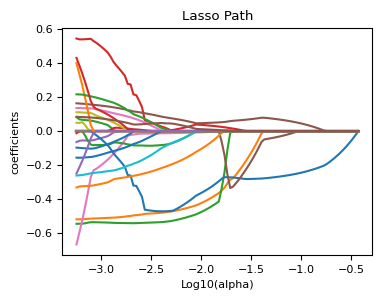

In [94]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')
plt.show()

In [95]:
# note: you could have also used a separate validation sample, just to find the optimal lambda

from sklearn.linear_model import LassoCV
import time

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-3, -1.0, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0027 
Training time =  33.2778s 


In [96]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

# to experiment: you can try polynomials with a higher degree, note: it might take time to compute

In-sample Rsq:  0.6533
Out-of-sample Rsq:  0.6430


# Conclusion

* Trees and forests are good tools when we expect to have non-linearities and interactions in our data + when we are agnostic about the data generation process
* Flexibility of the approach also makes the predictions less stable, highly variable: 
    * Stopping rules 
    * Pruning techniques - use CV to select a tree with a smaller number of terminal nodes
    * Bagging / Random forests - average over simple CART trees 
* There are other tree-based algorithms 
    * Boosted trees
    * Bayes Additive trees
    * Dynamic trees 
* Trees perform well when the number of parameters relative to $N$ is not very high and when observations are independent 
    * Otherwise, alternative techniques or additional data transformations

# Resources 

Matt Taddy (2019) Business Data Science: Combining Machine Learning and Economics to Optimize, Automate, and Accelerate Business Decisions. McGraw-Hill Education

James/Witten/Hastie/Tibrashini (2021) Introduction to Statistical Learning https://web.stanford.edu/~hastie/ISLR2/ISLRv2_website.pdf